# Выбор локации для скважины

Предоставлены данные пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Задачи:**
- Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 
- Проанализировать возможную прибыль и риски.

**Условия задач:**
- Бюджет на разработку скважин в регионе — 10 млрд рублей
- Доход с каждой единицы продукта - 450 тыс. рублей
- Оставить лишь те регионы, в которых вероятность убытков меньше 2.5%
- При обучении модели использовать линейную регрессию



### Импорт библиотек

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Константы

In [72]:
RANDOM_STATE = 0
RS = np.random.RandomState(RANDOM_STATE)

In [73]:
PRODUCT_PRICE = 450  # доход с единицы продукта тыс.руб.
WELLS_FOR_RESEARCH = 500  # кол-во точек для исследования
WELLS_FOR_USE = 200  # кол-во лучших точек для разработки скважин
BUDGET = 10**7  # бюджет на регион
ALPHA = .025

## Загрузка и подготовка данных

In [75]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')
geo_data_all = [geo_data_0, geo_data_1, geo_data_2]

Данные загружены, следует посмотреть на них.

In [77]:
for geo_data, i in zip(geo_data_all, range(len(geo_data_all))):
    print('{:^100}'.format(f'geo_data_{i}'), 'Метод .info()', sep='\n')                         
    geo_data.info()
    print('\n\n Пример данных')
    display(geo_data.sample(3))
    print(f'Построчных дубликатов: {geo_data.duplicated().sum()}')
    print(f'Дубликатов в id: {geo_data["id"].duplicated().sum()}')
    print(f'Дубликатов в значимых переменных: {geo_data[["f0","f1", "f2"]].duplicated().sum()}')
    print('\n\nМетод .describe()')  
    display(geo_data.describe())
    print('='*100)
    

                                             geo_data_0                                             
Метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


 Пример данных


,id,f0,f1,f2,product
26301,AVKWB,1.614116,-0.512059,1.374490,81.260278
4178,YqGRe,-1.012346,0.624864,1.069448,100.952284
97071,0B1oH,-0.289952,1.023344,6.444955,147.218163


Построчных дубликатов: 0
Дубликатов в id: 10
Дубликатов в значимых переменных: 0


Метод .describe()


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


                                             geo_data_1                                             
Метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


 Пример данных


,id,f0,f1,f2,product
48440,hXWO3,6.974782,-5.313980,2.003249,53.906522
23178,caLG4,2.845327,3.105171,4.991196,134.766305
77101,r2R1e,15.846632,-2.162240,3.999058,107.813044


Построчных дубликатов: 0
Дубликатов в id: 4
Дубликатов в значимых переменных: 0


Метод .describe()


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


                                             geo_data_2                                             
Метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


 Пример данных


,id,f0,f1,f2,product
34592,WQxBW,-1.578006,2.006387,-0.152390,123.246008
57835,MVFBk,-0.378476,1.650281,6.330137,92.369530
40038,V14hw,1.887855,-3.444073,-0.000920,105.431164


Построчных дубликатов: 0
Дубликатов в id: 4
Дубликатов в значимых переменных: 0


Метод .describe()


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В данных нет пропусков, но есть дубликаты `id`. Так-как записей очень много, а дубликатов наооборот, немного то дублирующиеся записи можно удалить целиком. Однако, так-как строки не дублируются в колонках значимых признаков то на модель такие дубликаты никак повлиять не должны.

In [79]:
geo_data_0 = geo_data_0[~geo_data_0["id"].duplicated(keep=False)]
geo_data_1 = geo_data_1[~geo_data_1["id"].duplicated(keep=False)]
geo_data_2 = geo_data_2[~geo_data_2["id"].duplicated(keep=False)]

In [80]:
geo_data_0 = geo_data_0.reset_index(drop=True)
geo_data_1 = geo_data_1.reset_index(drop=True)
geo_data_2 = geo_data_2.reset_index(drop=True)

Распределения признаков:

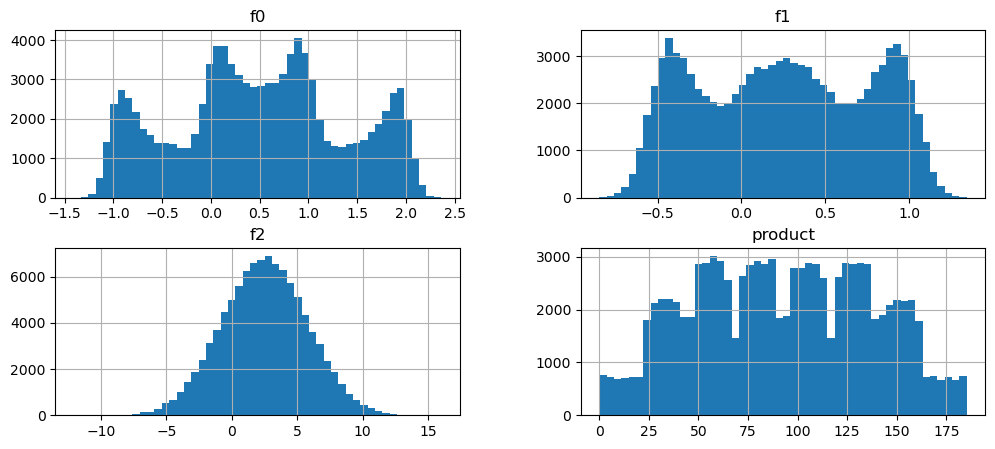

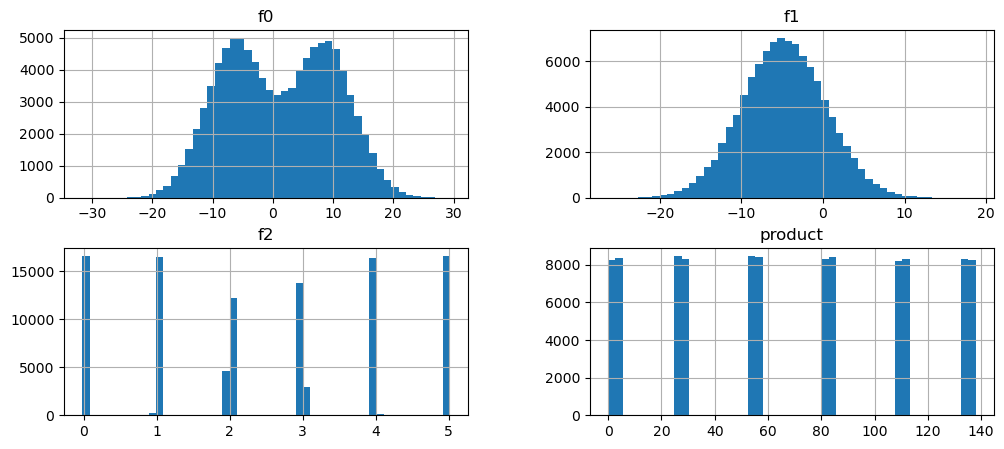

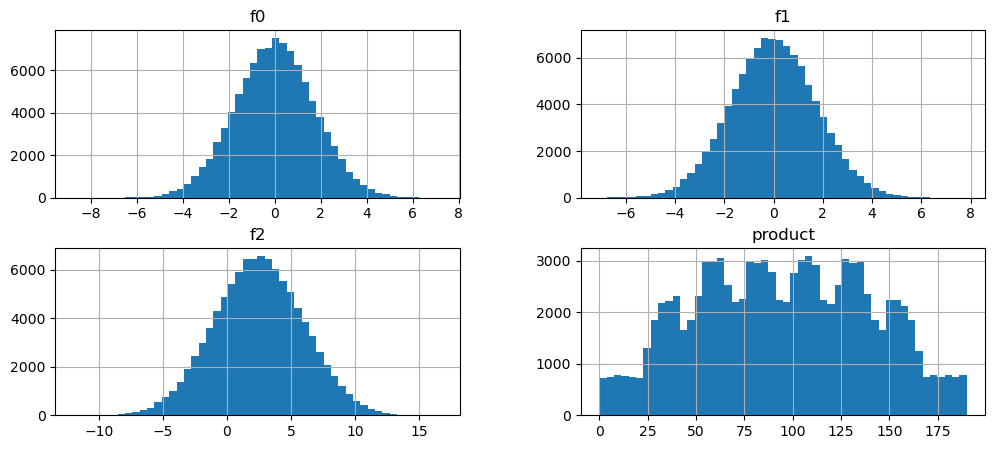

In [184]:
for geo_data in geo_data_all:
    geo_data.hist(bins=50, figsize=(12,5))
    plt.show();


## Обучение и проверка модели

###  Разбивка даннх на обучающую и валидационную выборки в соотношении 3/1.

In [85]:
geo_data_selection = []
for geo_data in geo_data_all:
    geo_data_selection.append(train_test_split(
        geo_data.drop(['product', 'id'], axis=1),
        geo_data['product'],
        test_size=0.25,
        random_state = RANDOM_STATE
    ))

### Обучение модели. Предсказания на валидационной выборке.

In [87]:
models = []
for X_train, X_test, y_train, y_test in geo_data_selection:
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred =  model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'rmse: {rmse:6.2f}, mean_product {y_pred.mean():6.2f}')
    models.append({
        'model': model,
        'rmse': rmse,
        'predict': y_pred,
        'true': y_test,
        'pred_true': pd.DataFrame(
            [
                pd.Series(y_test.values, name='true'),
                pd.Series(y_pred, name='pred')
            ]
        ).T.set_index(y_test.index)
    })


rmse:  37.48, mean_product  92.27
rmse:   0.89, mean_product  69.15
rmse:  40.31, mean_product  94.71


### Выводы.

Из трёх моделей сильно отличается модель региона `1`. Столь разительно отличающиеся показатели метрики похожи на утечку целевого признака, кроме того, ещё на этапе знакомства с данными были замечены странности в распределении параметров. Я бы попросил отдел занимающийся сбором и предоставлением данных перепроверить данные региона `1`. 
Другие две модели показывают параметры `rmse` схожие со стандартным отклонение данных показанным с помощью метода `.describe()`

## Подготовка к расчёту прибыли

Глобальные константы

In [91]:
budget_per_well = BUDGET/WELLS_FOR_USE
min_product_amount = budget_per_well/PRODUCT_PRICE
print(f'''Бюджет на 1 скважину: {budget_per_well:.0f} тыс.руб.
Минимальный запас нефти для окупаемости: >{min_product_amount:.4f}
Средние запасы в регионах:
    Регион 0: {geo_data_0['product'].mean():.2f}
    Регион 1: {geo_data_1['product'].mean():.2f}
    Регион 2: {geo_data_2['product'].mean():.2f}
''')

Бюджет на 1 скважину: 50000 тыс.руб.
Минимальный запас нефти для окупаемости: >111.1111
Средние запасы в регионах:
    Регион 0: 92.50
    Регион 1: 68.82
    Регион 2: 95.00



**Вывод**: Необходимый минимальный запас сырья для безубыточной разработки скважины: более 111, что превышает средние запасы в регионах. Из двух регионов, по показателю средних запасов нефти более перспективным выглядин регион `2`.

## Расчёт прибыли и рисков 

### Функция расчёта прибыли

In [95]:
def income_calculation(df, count, price): 
    """Возвращает сумарную прибыль в рублях count лучших скважин по предсказанному значению 
    запасов нефти за вычетом бюджета на разработку месторождений 
    """
    return (df.sort_values(by='pred',ascending=False).head(count)['true'].sum() * price - BUDGET) * 1000

income_calculation(models[2]['pred_true'], WELLS_FOR_USE, PRODUCT_PRICE)

2623878683.5164165

### Нахождение распределения прибыли на 1000 выборок.

In [199]:
income=[]
t = []
for model in models:
    for i in range(1000):
        sample = model['pred_true'].sample(WELLS_FOR_RESEARCH, replace=True, random_state=RS)
        t.append(income_calculation(sample, WELLS_FOR_USE, PRODUCT_PRICE))
    income.append(pd.Series(t))
    t.clear()

Распределение прибыли

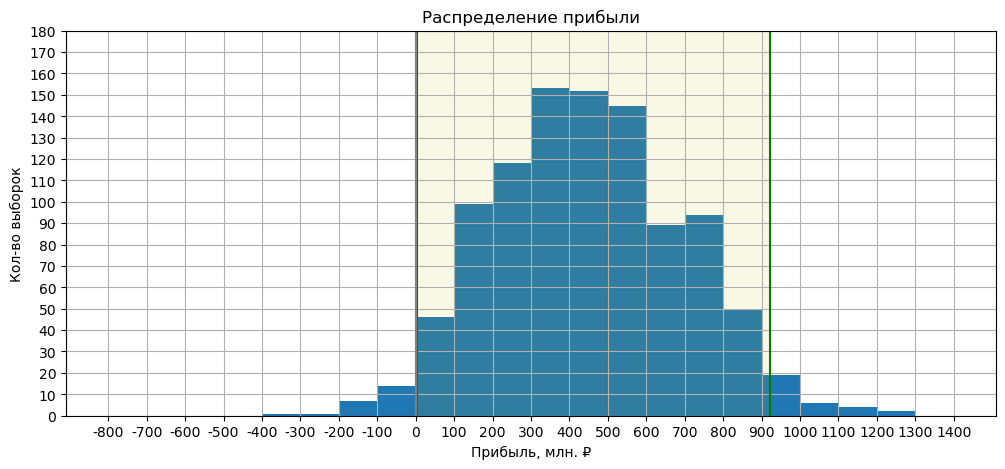

Средняя прибыль: 448,123,601₽ 
95% доверительный интервал: 4,467,510 - 920,776,964 ₽
Вероятность убытков 2.30% 





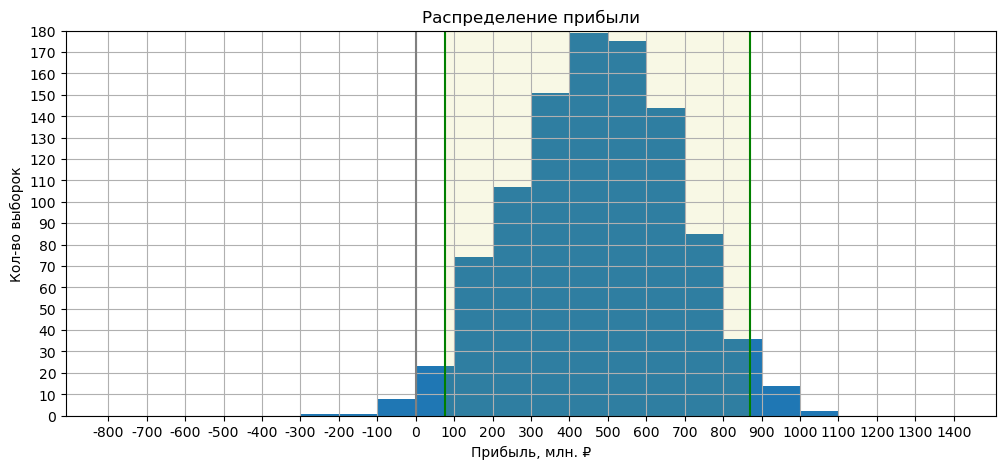

Средняя прибыль: 472,176,694₽ 
95% доверительный интервал: 75,262,703 - 870,175,016 ₽
Вероятность убытков 1.00% 





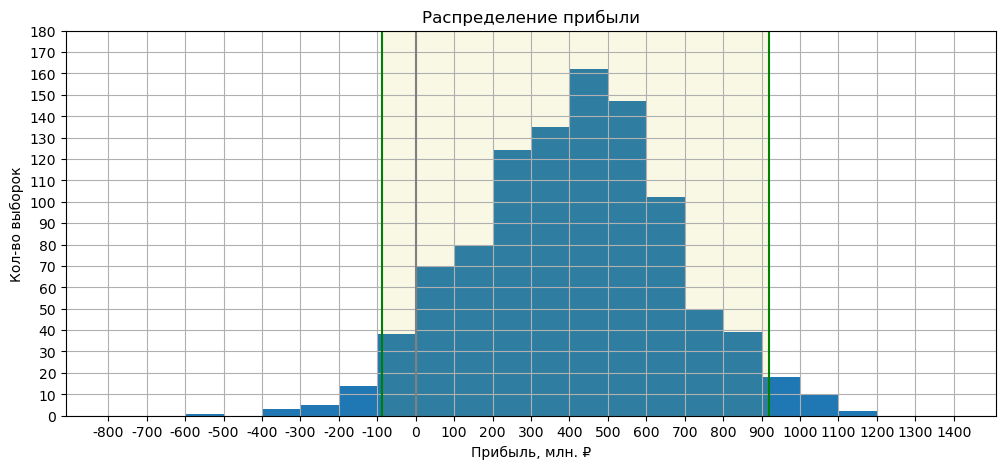

Средняя прибыль: 409,167,417₽ 
95% доверительный интервал: -87,513,885 - 918,096,822 ₽
Вероятность убытков 6.10% 





In [219]:
for model_income in income:
    model_income.hist(
        figsize=(12,5),
        bins=(t:=np.array(range(-8,15))*10**8)
    )
    plt.title('Распределение прибыли')
    plt.xlabel('Прибыль, млн. ₽')
    plt.ylabel('Кол-во выборок')
    lower = model_income.quantile(ALPHA)
    upper = model_income.quantile(1-ALPHA)
    plt.axvline(lower, color='green')
    plt.axvline(upper, color='green')
    plt.axvline(0, color='gray')
    plt.fill_betweenx([0,180],lower,upper, color='y', alpha=0.1)
    plt.xticks(ticks=t, labels=t//1000000)
    plt.yticks(np.array(range(0,181,10)))
    plt.ylim(top=180)
    plt.show();
    print(f'Средняя прибыль: {math.floor(model_income.mean()):,d}₽ ')
    print(f"95% доверительный интервал: {lower:,.0f} - {upper:,.0f} ₽")
    print(f'Вероятность убытков {1-model_income[model_income>0].shape[0] / model_income.shape[0]:.2%}', '\n'*3)
    

# Вывод:
По результатам построения модели и анализа возможной прибыли и рисков было установлено что:  
**Наиболее перспективным** является регион `geo_data_1`:
 - Удовлетворяет поставленным условиям
 - Имеет минимальные риски убытков
 - Имеет наибольшую среднюю прибыль по 1000 случайным выборкам 
 
**Итоги**:  
Только регион `geo_data_1` удовлетворяет условию, а также имеет лучшие параметры указанные выше. Именно данную локацию стоит выбрать для разработки нефтянных месторождений.